
# Constant Declaration and Module Imports

In [1]:
# import modules
import numpy as np
import pandas as pd
import sys
import os
import random
import warnings
import time

import matplotlib.pyplot as plt

import collections

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Dropout, Lambda
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from sklearn.model_selection import train_test_split

import tensorflow as tf 

from tqdm import tqdm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

/home/ubuntu/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


stage1_test
stage1_train



** Define constant (image size and images paths) **

In [2]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_DEPTH = 3
TRAIN_PATH = 'input/stage1_train/'
TEST_PATH = 'input/stage1_test/'

# set the seed for the random module. DO NOT ERASE.
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Data Download


  1%|          | 8/670 [00:00<00:10, 63.43it/s]

Generating training images ...


 26%|██▌       | 17/65 [00:00<00:00, 161.63it/s]

Generating test images ...


100%|██████████| 65/65 [00:00<00:00, 163.68it/s]


Calculating the dimensions of the training and test images...
----> Visualizing data through histograms ...


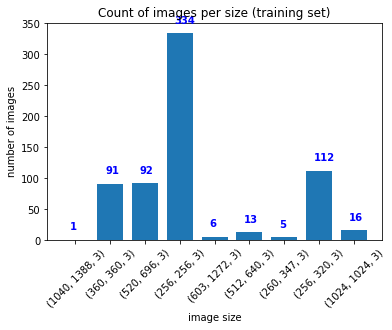

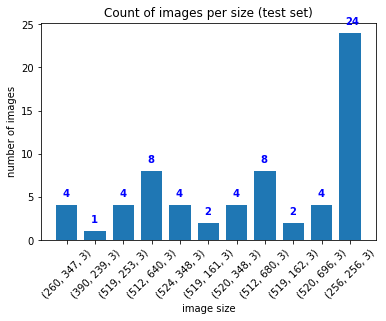

----> Visualizing data through tables ...


,Size,Count
0,"(1040, 1388, 3)",1
1,"(360, 360, 3)",91
2,"(520, 696, 3)",92
3,"(256, 256, 3)",334
4,"(603, 1272, 3)",6
5,"(512, 640, 3)",13
6,"(260, 347, 3)",5
7,"(256, 320, 3)",112
8,"(1024, 1024, 3)",16


The total number of training images is: 670


,Size,Count
0,"(260, 347, 3)",4
1,"(390, 239, 3)",1
2,"(519, 253, 3)",4
3,"(512, 640, 3)",8
4,"(524, 348, 3)",4
5,"(519, 161, 3)",2
6,"(520, 348, 3)",4
7,"(512, 680, 3)",8
8,"(519, 162, 3)",2
9,"(520, 696, 3)",4


The total number of test images is: 65


In [3]:
Xtrain = []
Xtest = []

# Create the ids of all training images and all the testing images.
try:
    train_ids = next(os.walk(TRAIN_PATH))[1]
except StopIteration:
    print('the ids of all training images created. There are {}'.format(len(train_ids)))

try:
    test_ids = next(os.walk(TEST_PATH))[1]
except StopIteration:
    print('the ids of all testing images created')  

# Create placeholder for images.
# I am using list because the shape of the images is unknown at this stage.
# Arrays require the declaration of dimensions.
X_train = []
X_test = []

# function that converts file name (string) into an image
def str_to_img(path, id_):
    img = imread(path + id_ + '/images/' + id_ + '.png')[:,:,:IMG_DEPTH]
    return img

# function that creates a bar chart from a counter
def barchart(counter, title):
    labels, values = zip(*counter.items())
    incr =  int(max(values)/20)
    indexes = np.arange(len(labels))
    width = 0.75
    fig, ax = plt.subplots()  
    plt.bar(indexes, values, width)
    plt.xticks(indexes, labels, rotation=45, fontsize=10)
    plt.title(title)
    plt.xlabel('image size', fontsize=10)
    plt.ylabel('number of images')
    for i, values in enumerate(counter.values()):
        ax.text(i - width*0.2, values+incr, str(values), color='blue', fontweight='bold')
    plt.show()
    
def print_table(counter, train_vs_test):
    pd_data_list = [list(counter.keys()), list(counter.values())]
    pd_data = pd.DataFrame(np.array(pd_data_list).T, columns=['Size', 'Count'])
    pd_data['Count'] = pd_data['Count'].apply(pd.to_numeric)
    # using 'display' instead of 'print' will use jupyter rich display logic.
    display(pd_data)
    print('The total number of '+train_vs_test+' images is: {}'.format(pd_data['Count'].sum()))
    
print('Generating training images ...')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    X_train.append(str_to_img(TRAIN_PATH, id_))

print('Generating test images ...')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    X_test.append(str_to_img(TEST_PATH, id_))

print('Calculating the dimensions of the training and test images...')    
# Analyze size of all training images and testing images
train_ids_size = [img.shape for img in X_train]
test_ids_size = [img.shape for img in X_test]
counter_train = collections.Counter(train_ids_size)
counter_test = collections.Counter(test_ids_size)

print('----> Visualizing data through histograms ...')
barchart(counter_train, "Count of images per size (training set)")
barchart(counter_test, "Count of images per size (test set)")

print('----> Visualizing data through tables ...')
print_table(counter_train, 'training')
print_table(counter_test, 'test')

In [4]:
# Create placeholder for images
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# Flush the buffer to see the progress in real time
sys.stdout.flush()

print('Getting and resizing training images ... ')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_DEPTH]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # normalize the images to float between 0 and 1
    X_train[n] = img / 255
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    # normalize the images to float between 0 and 1
    Y_train[n] = mask / 255

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_DEPTH]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # normalize the images to float between 0 and 1
    X_test[n] = img / 255

  0%|          | 0/670 [00:00<?, ?it/s]

Getting and resizing training images ... 


100%|██████████| 670/670 [01:56<00:00,  5.77it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 69.09it/s]


** Visualize an image and its mask **

In [5]:
# check the shape of X_train (the first four lines). Each image should have a size of (256, 256, 3).
print(X_train[1:5].shape)

(4, 256, 256, 3)


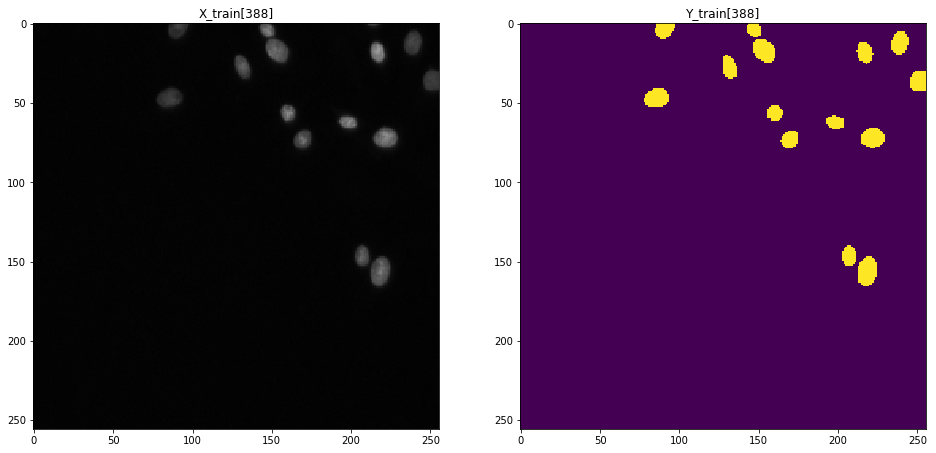

In [6]:
# Check some data
ind = random.randint(0, len(train_ids))
# Change the size of the plot
plt.rcParams["figure.figsize"] = [16,9]
# Draw two sets of images (train and test)
_, axarr = plt.subplots(1,2)
axarr[0].imshow(X_train[ind])
axarr[0].set_title("X_train["+str(ind)+"]")
axarr[1].imshow(np.squeeze(Y_train[ind]))
axarr[1].set_title("Y_train["+str(ind)+"]")
plt.show()

We can see that the nuclei are clearly segmented in the training data.

**Augment training data**

In [7]:
# define batch size (used in the generator and during training)
batch_size = 16

# define a helper function generator() to create the data generators
def generator():
    # define constants
    validation_split = 0.1
    seed_split = 42
    
    # start the clock
    start = time.time()

    # create Test/Train validation split
    X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X_train,
                                                                                Y_train,
                                                                                train_size=1-validation_split,
                                                                                test_size=validation_split,
                                                                                random_state=seed_split)

    data_gen_args = dict(shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         rotation_range=90,
                         fill_mode='reflect')

    train_image_datagen = ImageDataGenerator(**data_gen_args)
    train_mask_datagen = ImageDataGenerator(**data_gen_args)
    test_image_datagen = ImageDataGenerator()
    test_mask_datagen = ImageDataGenerator()

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied) 
    # Provide the same seed and keyword arguments to the fit and flow methods
    # (source: https://keras.io/preprocessing/image/)
    train_image_datagen.fit(X_train_split, augment=True, seed=42)
    train_mask_datagen.fit(Y_train_split, augment=True, seed=42)
    test_image_datagen.fit(X_train_split, augment=True, seed=42)
    test_mask_datagen.fit(Y_train_split, augment=True, seed=42)

    train_image_generator = train_image_datagen.flow(X_train_split, seed=42, batch_size=batch_size, shuffle=True)
    train_mask_generator = train_mask_datagen.flow(Y_train_split, seed=42, batch_size=batch_size, shuffle=True)
    test_image_generator = test_image_datagen.flow(X_test_split, seed=42, batch_size=batch_size, shuffle=True)
    test_mask_generator = test_mask_datagen.flow(Y_test_split, seed=42, batch_size=batch_size, shuffle=True)

    train_generator = zip(train_image_generator, train_mask_generator)
    test_generator = zip(test_image_generator, test_mask_generator)

    end = time.time()
    delta = end - start

    print('Data was augmented in {:6.2f} seconds'.format(delta))
    return (train_generator, test_generator)

In [8]:
# helper function to visualize augmented data
def visualize_augmented_data():
    for X_batch in train_image_datagen.flow(X_train, batch_size=9):
        # create a grid of 3x3 images
        for i in range(0, 9):
            plt.subplot(330 + 1 + i)
            plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
        # show the plot
        plt.show()
        break

    print('-'*50)
    
    for y_batch in train_mask_datagen.flow(Y_train, batch_size=9):
        # create a grid of 3x3 images
        for i in range(0, 9):
            plt.subplot(330 + 1 + i)
            plt.imshow(y_batch[i].reshape(IMG_WIDTH,IMG_HEIGHT), cmap=plt.get_cmap('gray'))
        # show the plot
        plt.show()
        break

**Define Keras Metric**

In [9]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

** Build The Benchmark**

In [10]:
# Build the benchmark model
def build_benchmark_initial():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (p1)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c1)
    model_benchmark = Model(inputs=[inputs], outputs=[outputs])
    model_benchmark.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    model_benchmark.summary()
    return model_benchmark

In [11]:
# Build the benchmark model
def build_benchmark():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c1)
    model_benchmark = Model(inputs=[inputs], outputs=[outputs])
    model_benchmark.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    model_benchmark.summary()
    return model_benchmark

** Create a helper function to train any model**

In [12]:
def train(model, model_file):
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint(model_file, verbose=1, save_best_only=True)
    results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50,
                        callbacks=[earlystopper, checkpointer])
    # summarize history for metrics
    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])
    plt.plot(results.history['mean_iou'])
    plt.plot(results.history['val_mean_iou'])
    plt.title('model accuracy')
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'test_loss', 'train_mean_iou', 'test_mean_iou'], loc='upper left')
    plt.show()

** Train benchmark model**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 1)       17        
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
_________________________________________________________________
Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 50s 84ms/step - loss: 0.5730 - mean_iou: 

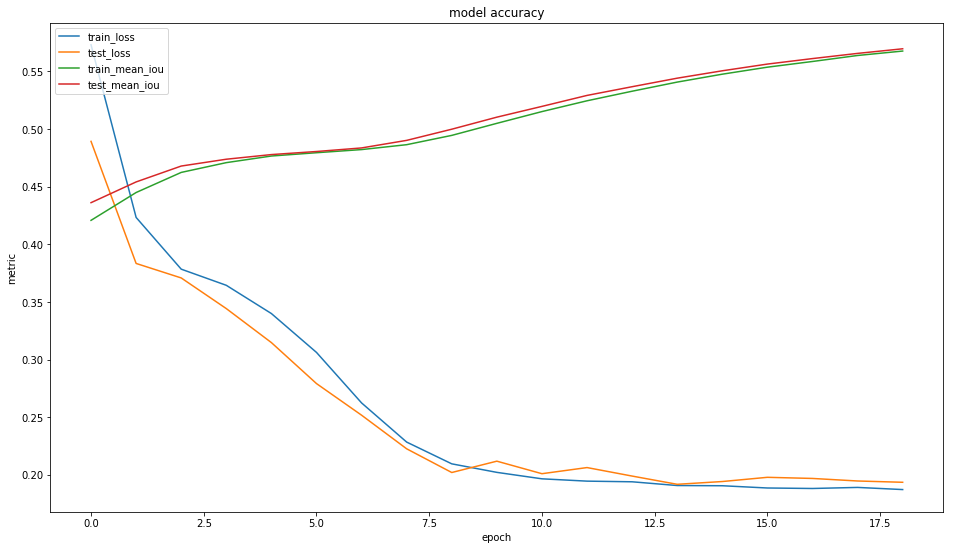

The benchmark model was trained in 916 seconds.


In [13]:
# create initial benchmark model
model_benchmark = build_benchmark_initial()
# fit model
start = time.time()
train(model_benchmark,'model-benchmark_initial_50.h5')
end = time.time()
delta = end - start
print('The benchmark model was trained in {:.0f} seconds.'.format(delta))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
dropout_10 (Dropout)         (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 256, 256, 1)       17        
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
_________________________________________________________________
Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 53s 89ms/step - loss: 0.6036 - mean_iou: 

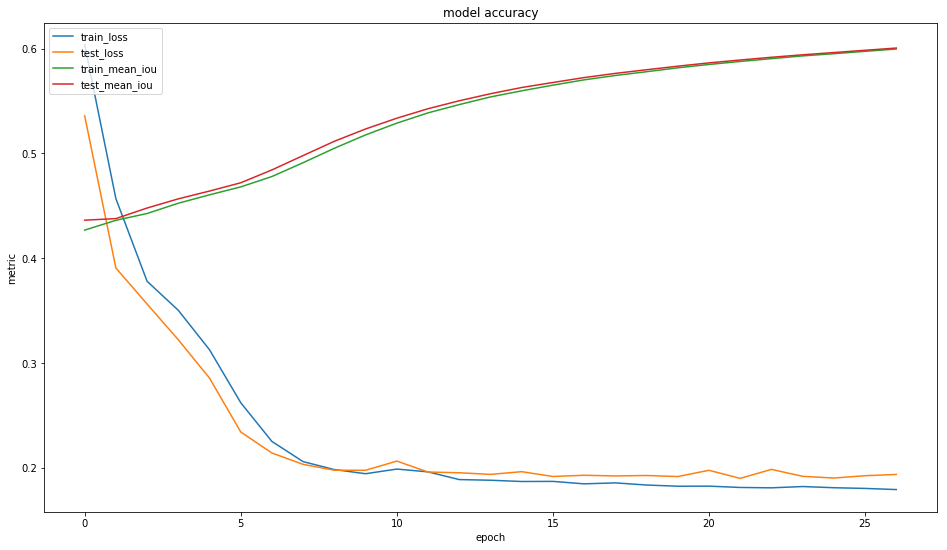

The benchmark model was trained in 1308 seconds.


In [27]:
# create benchmark model
model_benchmark = build_benchmark()
# fit model
start = time.time()
train(model_benchmark,'model-benchmark_50.h5')
end = time.time()
delta = end - start
print('The benchmark model was trained in {:.0f} seconds.'.format(delta))


**Build  The Neural Network**

The Unet architecture (used by Olaf Ronneberger, Philipp Fischer, and Thomas Brox).
Source: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png

Our network uses images which are twice as small.

![Unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [11]:
# Build U-Net model
def u_net():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    model.summary()
    return model

**Training the model with the original data**

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 256, 256, 16) 448         input_11[0][0]                   
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 256, 256, 16) 0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 256, 256, 16) 2320        dropout_11[0][0]                 
__________________________________________________________________________________________________
max_poolin

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 456s 756ms/step - loss: 0.4283 - mean_iou: 0.4303 - val_loss: 0.3085 - val_mean_iou: 0.4616

Epoch 00001: val_loss improved from inf to 0.30852, saving model to model-benchmark_50.h5
Epoch 2/50
603/603 [==============================] - 449s 745ms/step - loss: 0.2091 - mean_iou: 0.4974 - val_loss: 0.1313 - val_mean_iou: 0.5473

Epoch 00002: val_loss improved from 0.30852 to 0.13128, saving model to model-benchmark_50.h5
Epoch 3/50
603/603 [==============================] - 451s 748ms/step - loss: 0.1196 - mean_iou: 0.5842 - val_loss: 0.1033 - val_mean_iou: 0.6183

Epoch 00003: val_loss improved from 0.13128 to 0.10331, saving model to model-benchmark_50.h5
Epoch 4/50
603/603 [==============================] - 450s 746ms/step - loss: 0.1102 - mean_iou: 0.6422 - val_loss: 0.1019 - val_mean_iou: 0.6617

Epoch 00004: val_loss improved from 0.10331 to 0.10187, saving model to model-benchmark_5

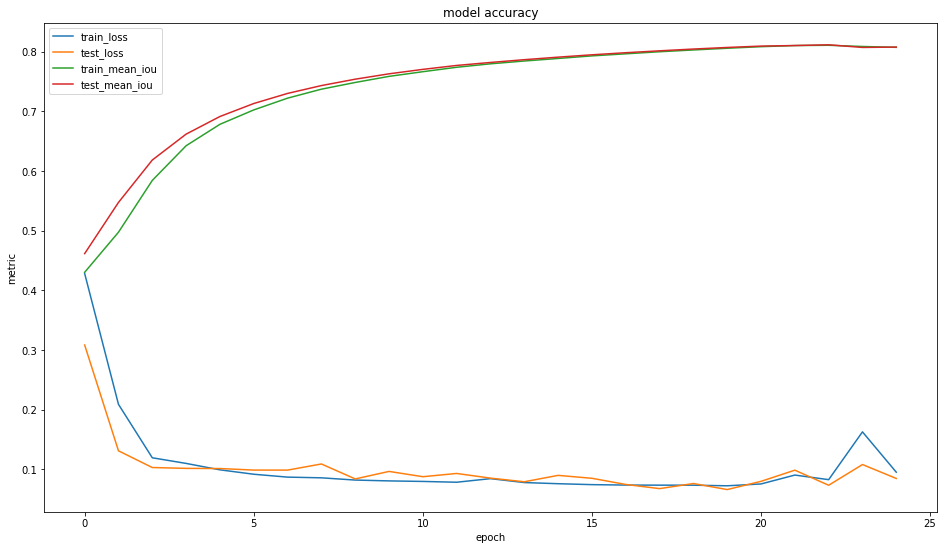

The Unet model using the original data was trained in 11271.82


In [31]:
# create model
model = u_net()
# Fit model without augmented data
start = time.time()
train(model,'model-dsbowl2018-50epochsF.h5')
end = time.time()
delta = end - start
print('The Unet model using the original data was trained in {:6.2f}'.format(delta))


#earlystopper = EarlyStopping(patience=5, verbose=1)
#checkpointer = ModelCheckpoint('model-dsbowl2018-50epochs.h5', verbose=1, save_best_only=True)
#results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
#                    callbacks=[earlystopper, checkpointer])

The Unet model using the original data was trained in 11271.82 seconds. We can see that training and test loss decreased while the mean_iou for both datasets increased steadily. 

**Train the model with augmented data**

In [12]:
# create model
model = u_net()

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-50epochs_augF.h5', verbose=1, save_best_only=True)

train_generator, test_generator = generator()

start = time.time()
model.fit_generator(train_generator,
                    steps_per_epoch=2000 // batch_size,
                    epochs=30,
                    validation_data=test_generator,
                    validation_steps=800 // batch_size,
                    verbose=1,
                    callbacks = [earlystopper, checkpointer])

end = time.time()
delta = end - start
print('The Unet model using the augmented data was trained in {:6.2f} seconds'.format(delta))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin

Data was augmented in  12.16 seconds
Epoch 1/30
125/125 [==============================] - 1669s 13s/step - loss: 0.1985 - mean_iou: 0.5526 - val_loss: 0.1372 - val_mean_iou: 0.6812

Epoch 00001: val_loss improved from inf to 0.13721, saving model to model-dsbowl2018-50epochs_augF.h5
Epoch 2/30
125/125 [==============================] - 1660s 13s/step - loss: 0.1003 - mean_iou: 0.7230 - val_loss: 0.0973 - val_mean_iou: 0.7520

Epoch 00002: val_loss improved from 0.13721 to 0.09731, saving model to model-dsbowl2018-50epochs_augF.h5
Epoch 3/30
125/125 [==============================] - 1662s 13s/step - loss: 0.0884 - mean_iou: 0.7681 - val_loss: 0.0861 - val_mean_iou: 0.7807

Epoch 00003: val_loss improved from 0.09731 to 0.08611, saving model to model-dsbowl2018-50epochs_augF.h5
Epoch 4/30
125/125 [==============================] - 1658s 13s/step - loss: 0.0812 - mean_iou: 0.7899 - val_loss: 0.0856 - val_mean_iou: 0.7969

Epoch 00004: val_loss improved from 0.08611 to 0.08557, saving mo

**Helper function to make Predictions**

In [19]:
# helper function to calculate predictions
def calculate_predictions(file_name):
    start = time.time()
    print('Starting prediction with the {} model'.format(file_name))
    # Predict on test data using the previous model
    #model = load_model('model-dsbowl2018-50epochs.h5', custom_objects={'mean_iou': mean_iou})
    model = load_model(file_name, custom_objects={'mean_iou': mean_iou})

    preds_test = model.predict(X_test, verbose=1)

    # Threshold predictions
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    # Create list of upsampled test masks
    preds_test_upsampled = []
    for i in range(len(preds_test)):
        preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                           (sizes_test[i][0], sizes_test[i][1]), 
                                           mode='constant', preserve_range=True))
    end = time.time()
    delta_time = end - start
    print('The prediction with the {} model took {:6.2f} seconds'.format(file_name, delta_time))
    return preds_test_t, preds_test_upsampled

**Helper function to visualize a random image and its prediction**

In [20]:
def visualize_test(preds_test_t, random_id):
    # this function takes two variables : the test predition and random_id
    # random_id is the id of an image. It is either equal to an integer or to 'None'

    if random_id == 'None':
        ind = random.randint(0, len(preds_test_t))
    else:
        ind = random_id
    # Change the size of the plot
    plt.rcParams["figure.figsize"] = [16,9]
    # Draw two sets of images
    _, axarr = plt.subplots(1,2)
    axarr[0].imshow(X_test[ind])
    axarr[0].set_title("X_test["+str(ind)+"]")
    axarr[1].imshow(np.squeeze(preds_test_t[ind]))
    axarr[1].set_title("preds_test_t["+str(ind)+"]")
    plt.show()


**Helper function to encode **

In [21]:
# Run-length encoding from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    # flatten the image (as per pixel convention) and keep the pixels where the mask is 
    dots = np.where(x.T.flatten() == 1)[0]
    # define the lengths of the runs
    run_lengths = []
    # reset comparison point
    prev = -2
    for b in dots:
        # start a new pair for non-contiguous pixels
        if (b>prev+1):
            run_lengths.extend((b + 1, 0))
        # increase the run length of the last item in the list by 1
        run_lengths[-1] += 1
        # assign comparison point to the pixel in dots
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    # label image regions
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [22]:
# helper function to create test_ids and run length encoding
def new_test_ids(preds_test_upsampled):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ids):
        rle = list(prob_to_rles(preds_test_upsampled[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    return new_test_ids, rles

In [23]:
# Create submission DataFrame
def create_submission_dataframe(new_test_ids, rles, file_name):
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv(file_name, index=False)


**Make Predictions**

Benchmark Model
Starting prediction with the model-benchmark_50.h5 model
65/65 [==============================] - 3s 40ms/step
The prediction with the model-benchmark_50.h5 model took  32.56 seconds
visualization with random image


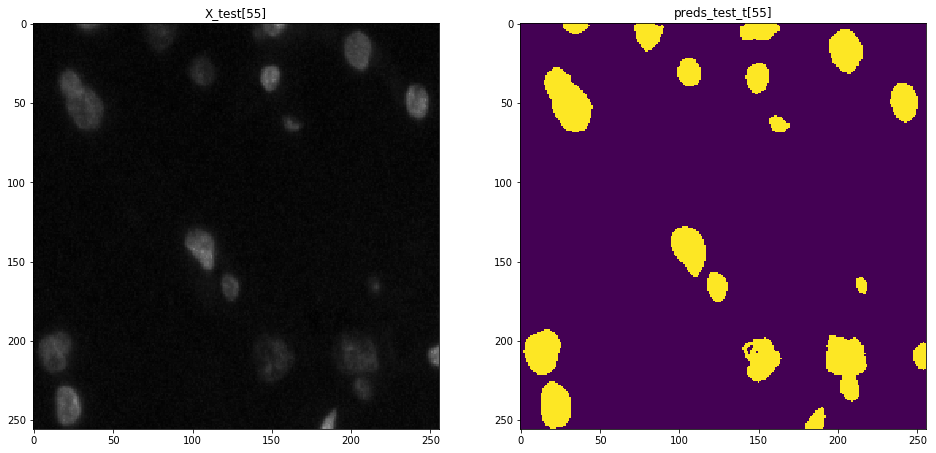

visualization with image number 10


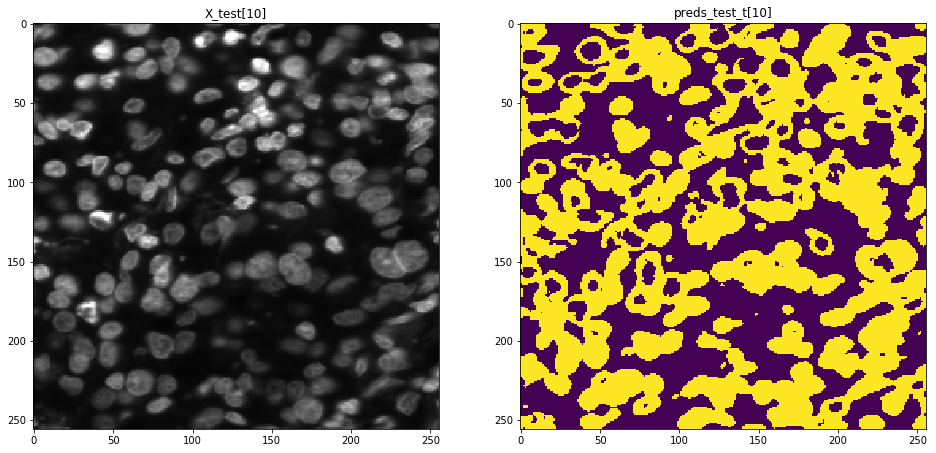



Unet Model with original data
Starting prediction with the model-dsbowl2018-50epochsF.h5 model
65/65 [==============================] - 23s 358ms/step
The prediction with the model-dsbowl2018-50epochsF.h5 model took  57.61 seconds
visualization with random image


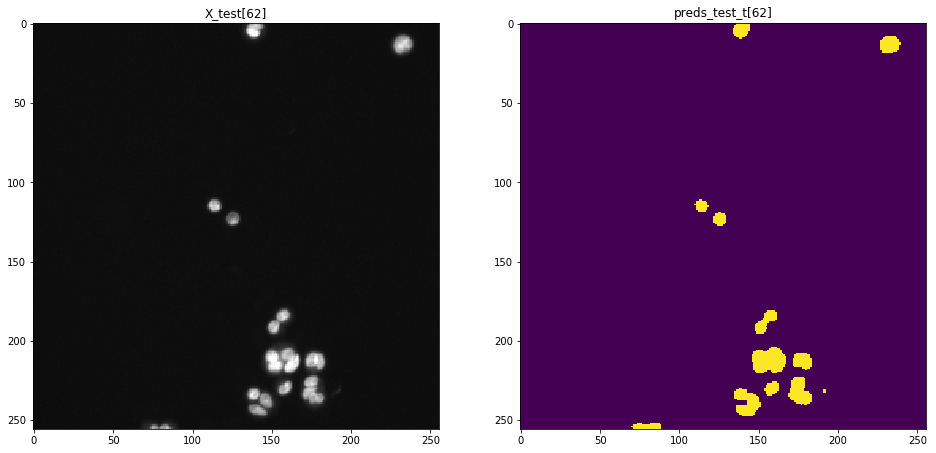

visualization with image number 10


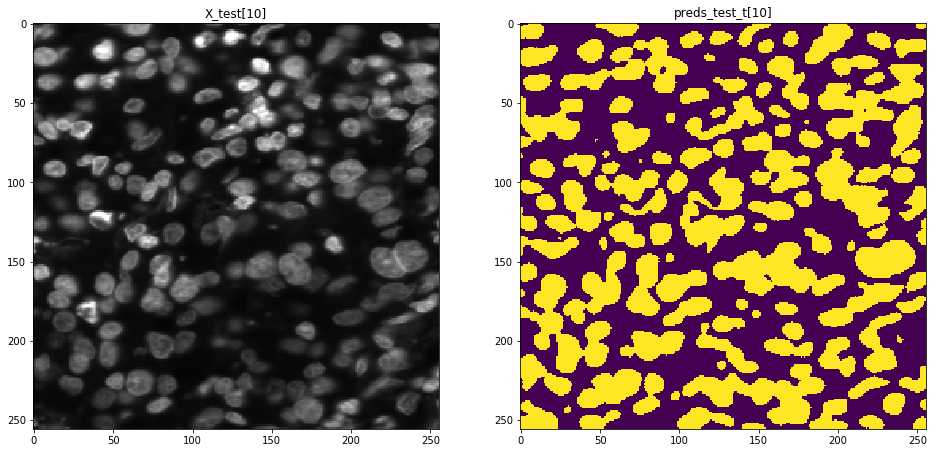



Unet Model with augmented data
Starting prediction with the model-dsbowl2018-50epochs_augF.h5 model
65/65 [==============================] - 23s 349ms/step
The prediction with the model-dsbowl2018-50epochs_augF.h5 model took  60.69 seconds
visualization with random image


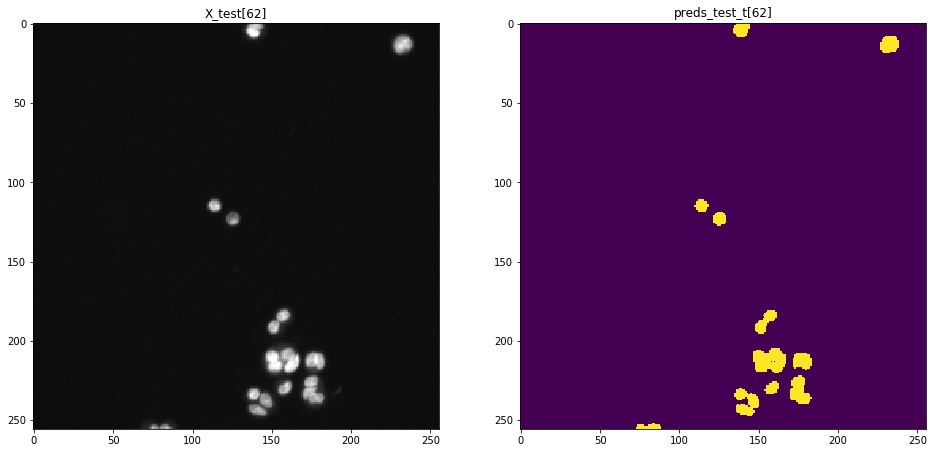

visualization with image number 10


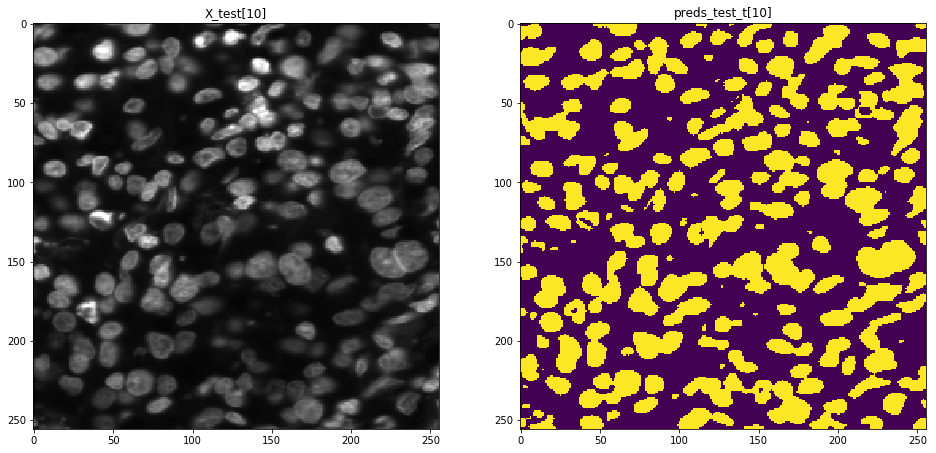

In [28]:
# helper function to calculate predictions and create csv file
def predictions_csv(modele_name, modele_file, csv_file):
    random_id = 10
    
    print(modele_name)
    new_test_ids_ = []
    rles = []
    preds_test_t, preds_test_upsampled = calculate_predictions(modele_file)
    print('visualization with random image')
    visualize_test(preds_test_t, 'None')
    new_test_ids_, rles = new_test_ids(preds_test_upsampled)
    create_submission_dataframe(new_test_ids_, rles, csv_file)
    print('visualization with image number {}'.format(random_id))
    visualize_test(preds_test_t, random_id)


predictions_csv('Benchmark Model', 'model-benchmark_50.h5', 'model-benchmark_50.csv')
print('\n')
predictions_csv('Unet Model with original data', 'model-dsbowl2018-50epochsF.h5', 'model-dsbowl2018-50epochsF.csv')
print('\n')
predictions_csv('Unet Model with augmented data', 'model-dsbowl2018-50epochs_augF.h5', 'model-dsbowl2018-50epochs_augF.csv')
